# What sells a car?


I'm an analyst at Crankshaft List. Hundreds of free advertisements for vehicles are published on our site every day. The main goal of this analysis is to determine which factors influence the price of a vehicle.

Plan for the analysis
1. Inspect the data.
2. Address issues by fixing missing values, removing duplicates, and correcting data types.
3. Enhance the data if needed - if some information was not provided in the initial dataset, but could be calculated out of it.
4. Explore core parameters and their distributions, identify outliers, filter if required, and visualize.
5. Draw conclusions based on the results of my analysis.


## Initialization

In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
import datetime as dt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'
import seaborn as sns
import matplotlib.pyplot as plt

### Load data

Let's load the data and have a look at the general information

In [2]:
# Load the data file into a DataFrame
try:
    ads = pd.read_csv('vehicles_us.csv')
except:
    ads = pd.read_csv('/datasets/vehicles_us.csv')


### Explore initial data

The dataset contains the following fields:
- `price`
- `model_year`
- `model`
- `condition`
- `cylinders`
- `fuel` — gas, diesel, etc.
- `odometer` — the vehicle's mileage when the ad was published
- `transmission`
- `paint_color`
- `is_4wd` — whether the vehicle has 4-wheel drive (Boolean type)
- `date_posted` — the date the ad was published
- `days_listed` — from publication to removal


In [3]:
# print the general/summary information about the DataFrame
ads.shape


(51525, 13)

In [4]:
ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         51525 non-null  int64  
 1   model_year    47906 non-null  float64
 2   model         51525 non-null  object 
 3   condition     51525 non-null  object 
 4   cylinders     46265 non-null  float64
 5   fuel          51525 non-null  object 
 6   odometer      43633 non-null  float64
 7   transmission  51525 non-null  object 
 8   type          51525 non-null  object 
 9   paint_color   42258 non-null  object 
 10  is_4wd        25572 non-null  float64
 11  date_posted   51525 non-null  object 
 12  days_listed   51525 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 5.1+ MB


In [5]:
ads.describe()

,price,model_year,cylinders,odometer,is_4wd,days_listed
count,51525.000000,47906.000000,46265.000000,43633.000000,25572.0,51525.00000
mean,12132.464920,2009.750470,6.125235,115553.461738,1.0,39.55476
std,10040.803015,6.282065,1.660360,65094.611341,0.0,28.20427
min,1.000000,1908.000000,3.000000,0.000000,1.0,0.00000
25%,5000.000000,2006.000000,4.000000,70000.000000,1.0,19.00000
50%,9000.000000,2011.000000,6.000000,113000.000000,1.0,33.00000
75%,16839.000000,2014.000000,8.000000,155000.000000,1.0,53.00000
max,375000.000000,2019.000000,12.000000,990000.000000,1.0,271.00000


In [6]:
ads.duplicated().sum()

0

### What we see in the data? 

Firstly, it has 51525 rows and 13 columns. 

Secondly, some of the columns has missing values. They are:
* `model_year`
* `cylinders`
* `odometer`
* `paint_color`
* `is_4wd`

Thirdly, there are some columns with unexpected data types.
* `model_year` is a float instead of an integer.
* `cylinders` is a float instead of an integer.
* `is_4wd` is a float too. And as I noticed before it has missing values. It is known that this column has a boolean-type values, so NaN is simply means that a vehicle doesn't have a 4-wheel drive. I think it's better be presented without missing values.
* `date_posted` is an object instead of the datetime.

Fourthly, the values in `price` column are vary from 1 to 375000 - are those even real prices?

Fifthly, `model_year` column has minimum at 1908. Is it mistake or some cars are actually so old?

Sixthly, `odometer` has min at 0. Is the data in the column representing new cars?  And difference between 75% and max value is quite big - those outliers we also need to take into account.

Seventhly, `days_listed` also has some outliers - min is at 0 and max is at 271. Ads were just posted? The cars were sold whithin one day? 

Eithly, there are no duplicates

Let's explore the data futher - look at the part of the data and overall distribution.

In [7]:
# print a sample of data
ads.head(20)


,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003.0,ford f-150,fair,8.0,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28
5,14990,2014.0,chrysler 300,excellent,6.0,gas,57954.0,automatic,sedan,black,1.0,2018-06-20,15
6,12990,2015.0,toyota camry,excellent,4.0,gas,79212.0,automatic,sedan,white,NaN,2018-12-27,73
7,15990,2013.0,honda pilot,excellent,6.0,gas,109473.0,automatic,SUV,black,1.0,2019-01-07,68
8,11500,2012.0,kia sorento,excellent,4.0,gas,104174.0,automatic,SUV,NaN,1.0,2018-07-16,19
9,9200,2008.0,honda pilot,excellent,NaN,gas,147191.0,automatic,SUV,blue,1.0,2019-02-15,17


Let's examine the overall distribution within the columns in order to become familiar with the data

In [8]:
for i in ads:
    print(ads[i].value_counts())
    print('------------------NEXT-COLUMN-----------------------')

1        798
6995     719
5995     655
4995     624
3500     620
        ... 
58500      1
3993       1
32987      1
3744       1
7455       1
Name: price, Length: 3443, dtype: int64
------------------NEXT-COLUMN-----------------------
2013.0    3549
2012.0    3468
2014.0    3448
2011.0    3375
2015.0    3323
          ... 
1948.0       1
1961.0       1
1936.0       1
1949.0       1
1929.0       1
Name: model_year, Length: 68, dtype: int64
------------------NEXT-COLUMN-----------------------
ford f-150                           2796
chevrolet silverado 1500             2171
ram 1500                             1750
chevrolet silverado                  1271
jeep wrangler                        1119
                                     ... 
ford f-250 super duty                 241
acura tl                              236
kia sorento                           236
nissan murano                         235
mercedes-benz benze sprinter 2500      41
Name: model, Length: 100, dtype: int64
--

Let's see if we have a lot of rows with missing values in all three important columns.

In [9]:
ads[(ads.model_year.isna()) & (ads.cylinders.isna()) & (ads.odometer.isna())].sort_values(by='model')
ads[(ads.model_year.isna()) & (ads.cylinders.isna()) & (ads.odometer.isna())].shape



,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
35152,12999,NaN,chevrolet cruze,excellent,NaN,gas,NaN,automatic,sedan,red,NaN,2018-07-05,90
43358,3195,NaN,chevrolet impala,excellent,NaN,gas,NaN,automatic,sedan,purple,NaN,2018-08-26,33
42826,28888,NaN,chevrolet silverado 1500,excellent,NaN,gas,NaN,automatic,pickup,black,1.0,2019-01-10,19
25071,22998,NaN,chevrolet silverado 1500,excellent,NaN,gas,NaN,automatic,truck,red,1.0,2019-02-15,30
21013,21990,NaN,chevrolet silverado 3500hd,good,NaN,gas,NaN,automatic,truck,white,NaN,2018-08-09,36
47139,12500,NaN,chevrolet traverse,good,NaN,gas,NaN,automatic,SUV,NaN,1.0,2018-06-22,35
21232,9700,NaN,chrysler 300,excellent,NaN,gas,NaN,automatic,sedan,silver,NaN,2018-09-01,12
44707,23586,NaN,ford edge,like new,NaN,gas,NaN,automatic,SUV,NaN,1.0,2018-05-05,44
21782,4411,NaN,ford explorer,excellent,NaN,gas,NaN,automatic,SUV,blue,NaN,2018-05-02,72
39025,10911,NaN,ford explorer,excellent,NaN,gas,NaN,automatic,SUV,silver,1.0,2019-02-17,56


(59, 13)

59 rows out of more than 51 thousand it's not much. I dont think that I need to deal with this problem separately.

I observed that some of the model names in the data samples are inconsistent in spelling, such as "ford f-250 sd" and "ford f-250 super duty". Let's examine the model names and determine if this is an issue that requires resolution.

In [10]:
for i in ads.model.sort_values().unique():
    print(i)




acura tl
bmw x5
buick enclave
cadillac escalade
chevrolet camaro
chevrolet camaro lt coupe 2d
chevrolet colorado
chevrolet corvette
chevrolet cruze
chevrolet equinox
chevrolet impala
chevrolet malibu
chevrolet silverado
chevrolet silverado 1500
chevrolet silverado 1500 crew
chevrolet silverado 2500hd
chevrolet silverado 3500hd
chevrolet suburban
chevrolet tahoe
chevrolet trailblazer
chevrolet traverse
chrysler 200
chrysler 300
chrysler town & country
dodge charger
dodge dakota
dodge grand caravan
ford econoline
ford edge
ford escape
ford expedition
ford explorer
ford f-150
ford f-250
ford f-250 sd
ford f-250 super duty
ford f-350 sd
ford f150
ford f150 supercrew cab xlt
ford f250
ford f250 super duty
ford f350
ford f350 super duty
ford focus
ford focus se
ford fusion
ford fusion se
ford mustang
ford mustang gt coupe 2d
ford ranger
ford taurus
gmc acadia
gmc sierra
gmc sierra 1500
gmc sierra 2500hd
gmc yukon
honda accord
honda civic
honda civic lx
honda cr-v
honda odyssey
honda pilot
hy

All the Ford F series are inconsistent in spelling, let's standardize them.

In [11]:
y = {
    'ford f-150' : 'ford f150',
    'ford f-250' : 'ford f250',   
    'ford f-250 sd' : 'ford f250 sd',
    'ford f-250 super duty' : 'ford f250 sd',
    'ford f250 super duty' : 'ford f250 sd',
    'ford f-350 sd': 'ford f350 sd',
    'ford f350 super duty': 'ford f350 sd'
}

ads['model'] = ads['model'].replace(y)
for i in ads.model.sort_values().unique():
    print(i)

    


acura tl
bmw x5
buick enclave
cadillac escalade
chevrolet camaro
chevrolet camaro lt coupe 2d
chevrolet colorado
chevrolet corvette
chevrolet cruze
chevrolet equinox
chevrolet impala
chevrolet malibu
chevrolet silverado
chevrolet silverado 1500
chevrolet silverado 1500 crew
chevrolet silverado 2500hd
chevrolet silverado 3500hd
chevrolet suburban
chevrolet tahoe
chevrolet trailblazer
chevrolet traverse
chrysler 200
chrysler 300
chrysler town & country
dodge charger
dodge dakota
dodge grand caravan
ford econoline
ford edge
ford escape
ford expedition
ford explorer
ford f150
ford f150 supercrew cab xlt
ford f250
ford f250 sd
ford f350
ford f350 sd
ford focus
ford focus se
ford fusion
ford fusion se
ford mustang
ford mustang gt coupe 2d
ford ranger
ford taurus
gmc acadia
gmc sierra
gmc sierra 1500
gmc sierra 2500hd
gmc yukon
honda accord
honda civic
honda civic lx
honda cr-v
honda odyssey
honda pilot
hyundai elantra
hyundai santa fe
hyundai sonata
jeep cherokee
jeep grand cherokee
jeep gra

### Conclusions and further steps

Upon reviewing the data samples and general information, it is clear that there are problems that need to be addressed. In order to proceed with the analysis, I will first address missing values and inappropriate data types.

## Missing values

As previously mentioned, there are missing values in several columns across the dataframe, including
* `model_year`, 
* `cylinders`, 
* `odometer`, 
* `paint_color`, 
* `is_4wd`. 

Some of these columns are significant factors in determining the price of a vehicle. Let's investigate further by counting the number of missing values in each column and considering the best course of action for handling them.

### `model_year`

In [12]:
ads.model_year.isna().sum()
ads.model_year.isna().sum()/len(ads.model_year)
ads[ads.model_year.isna()]

3619

0.07023774866569626

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
1,25500,NaN,ford f150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
20,6990,NaN,chevrolet tahoe,excellent,8.0,gas,147485.0,automatic,SUV,silver,1.0,2018-08-05,28
65,12800,NaN,ford f150,excellent,6.0,gas,108500.0,automatic,pickup,white,NaN,2018-09-23,15
69,7800,NaN,ford f150,like new,8.0,gas,97510.0,automatic,truck,white,1.0,2019-02-20,39
72,3650,NaN,subaru impreza,excellent,NaN,gas,74000.0,automatic,sedan,blue,1.0,2018-08-07,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51464,8890,NaN,ford f250 sd,good,8.0,gas,135778.0,automatic,truck,red,1.0,2018-11-28,24
51465,34595,NaN,gmc yukon,excellent,8.0,gas,86456.0,automatic,SUV,silver,1.0,2019-04-18,13
51487,1495,NaN,ford f150,fair,6.0,gas,15804.0,manual,truck,white,1.0,2018-09-18,56
51488,21900,NaN,chevrolet silverado 3500hd,excellent,8.0,diesel,203000.0,automatic,truck,white,1.0,2018-12-27,37


In [13]:
for i in ads:
    print(ads[ads.model_year.isna()][i].value_counts())
    print('------------------NEXT-COLUMN-----------------------')

6500     58
5500     54
1        52
3500     43
7995     43
         ..
41990     1
2899      1
23888     1
16100     1
8890      1
Name: price, Length: 946, dtype: int64
------------------NEXT-COLUMN-----------------------
Series([], Name: model_year, dtype: int64)
------------------NEXT-COLUMN-----------------------
ford f150                            230
chevrolet silverado 1500             155
ram 1500                             117
chevrolet silverado                   98
ram 2500                              80
                                    ... 
buick enclave                         14
hyundai santa fe                      13
acura tl                              12
honda civic lx                        11
mercedes-benz benze sprinter 2500      7
Name: model, Length: 95, dtype: int64
------------------NEXT-COLUMN-----------------------
excellent    1699
good         1450
like new      333
fair          115
salvage        12
new            10
Name: condition, dtype: int64


7% of the `model_year` is missing, which is not a large percentage, but I wouldn't consider deleting it as it could result in losing meaningful information in other columns. After analyzing the distribution of the filtered data with missing values in model_year, I didn't see any patterns or correlations. Therefore, I will assume that this information was simply not provided in the advertisement.

To address the missing values in `model_year`, I will fill them with the most common value for each specific model.

In [14]:
ads['model_year'] = ads.groupby(['model'])['model_year'].transform(lambda grp: grp.fillna(grp.mode().max()))
ads['model_year'].isna().sum()

0

I would change the data type in this column to integer because I seems logical to me - a year is an integer, not a float number.

In [15]:
ads['model_year'] = ads['model_year'].astype(int)
ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         51525 non-null  int64  
 1   model_year    51525 non-null  int64  
 2   model         51525 non-null  object 
 3   condition     51525 non-null  object 
 4   cylinders     46265 non-null  float64
 5   fuel          51525 non-null  object 
 6   odometer      43633 non-null  float64
 7   transmission  51525 non-null  object 
 8   type          51525 non-null  object 
 9   paint_color   42258 non-null  object 
 10  is_4wd        25572 non-null  float64
 11  date_posted   51525 non-null  object 
 12  days_listed   51525 non-null  int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 5.1+ MB


### `cylinders`

In [16]:
ads.cylinders.isna().sum()
ads.cylinders.isna().sum()/len(ads.cylinders)
ads[ads.cylinders.isna()]
ads.cylinders.value_counts()

5260

0.10208636584182436

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
9,9200,2008,honda pilot,excellent,NaN,gas,147191.0,automatic,SUV,blue,1.0,2019-02-15,17
36,10499,2013,chrysler 300,good,NaN,gas,88042.0,automatic,sedan,NaN,NaN,2018-05-05,22
37,7500,2005,toyota tacoma,good,NaN,gas,160000.0,automatic,pickup,NaN,NaN,2018-07-22,44
59,5200,2006,toyota highlander,good,NaN,gas,186000.0,automatic,SUV,green,NaN,2018-12-20,2
63,30000,1966,ford mustang,excellent,NaN,gas,51000.0,manual,convertible,red,NaN,2019-01-23,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51429,3250,2004,toyota camry,good,NaN,gas,179412.0,automatic,sedan,NaN,NaN,2018-07-02,25
51442,28990,2018,ford f150,excellent,NaN,gas,10152.0,automatic,truck,white,1.0,2018-06-13,47
51460,5995,2007,ford fusion,excellent,NaN,gas,88977.0,manual,sedan,silver,NaN,2019-03-27,66
51477,6499,2007,acura tl,good,NaN,gas,112119.0,automatic,sedan,white,NaN,2018-06-22,28


8.0     15844
6.0     15700
4.0     13864
10.0      549
5.0       272
3.0        34
12.0        2
Name: cylinders, dtype: int64

In [17]:
for i in ads:
    print(ads[ads.cylinders.isna()][i].value_counts())
    print('------------------NEXT-COLUMN-----------------------')

6995     87
4995     71
1        71
7995     70
4500     70
         ..
16295     1
18487     1
27243     1
33765     1
2775      1
Name: price, Length: 1147, dtype: int64
------------------NEXT-COLUMN-----------------------
2013    408
2012    402
2015    399
2014    397
2011    363
2007    330
2008    326
2016    314
2010    304
2017    268
2006    263
2009    224
2005    200
2018    199
2004    171
2003    150
2002     98
2001     76
2000     72
1999     57
1997     37
2019     33
1995     29
1998     24
1996     18
1994     17
1993     12
1991     10
1989      9
1986      5
1990      5
1977      4
1971      4
1988      4
1966      4
1973      3
1992      3
1980      2
1984      2
1978      2
1975      2
1965      2
1987      1
1969      1
1964      1
1954      1
1963      1
1979      1
1949      1
1982      1
Name: model_year, dtype: int64
------------------NEXT-COLUMN-----------------------
ford f150                            355
chevrolet silverado 1500             231
ram 1500 

10% of the data is too substantial to be dropped. As previously stated, deleting missing values in one column could result in losing meaningful information in the other.

Upon reviewing the distribution of the filtered data with missing values in `cylinders`, I didn't see any patterns or correlations, leading me to believe that this information was also not provided in the advertisement.

To estimate the number of cylinders in a vehicle, I need to identify relevant parameters beyond just the model. I will investigate further by examining examples.

In [18]:
ads_with_cylinders = ads[ads.cylinders.notna()]

ads_with_cylinders[ads_with_cylinders['model'] == 'ford f150'].head(10).sort_values(by='cylinders')

ads_with_cylinders.query('model == "ford f150" and model_year == 2013').cylinders.value_counts()
ads_with_cylinders.query('model == "ford f150" and model_year == 2009').cylinders.value_counts()
ads_with_cylinders.query('model == "ford f150" and model_year == 2006').cylinders.value_counts()



,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
1,25500,2013,ford f150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
50,6200,2006,ford f150,excellent,6.0,gas,69698.0,automatic,truck,custom,NaN,2018-05-03,50
65,12800,2013,ford f150,excellent,6.0,gas,108500.0,automatic,pickup,white,NaN,2018-09-23,15
3,1500,2003,ford f150,fair,8.0,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
39,8000,2009,ford f150,good,8.0,gas,234000.0,automatic,truck,black,1.0,2019-03-31,1
69,7800,2013,ford f150,like new,8.0,gas,97510.0,automatic,truck,white,1.0,2019-02-20,39
139,19500,2014,ford f150,excellent,8.0,gas,116000.0,automatic,truck,grey,1.0,2018-06-26,40
140,2000,1993,ford f150,good,8.0,gas,258225.0,automatic,truck,red,NaN,2019-03-06,34
192,5295,2005,ford f150,good,8.0,gas,225000.0,automatic,pickup,white,1.0,2018-06-19,15
197,10000,2006,ford f150,excellent,8.0,gas,181000.0,automatic,truck,silver,1.0,2018-07-17,9


8.0    258
6.0    214
4.0      5
Name: cylinders, dtype: int64

8.0    77
6.0     2
Name: cylinders, dtype: int64

8.0    107
6.0     30
Name: cylinders, dtype: int64

The model Ford f150 has different number of cylinders and this characteristic vary from year to year.
I'd fill those missing values by most common value on every particular model produced on every year.

In [19]:
ads['cylinders'] = ads.groupby(['model',
                                'model_year'])['cylinders'].transform(lambda grp: grp.fillna(grp.mode().max()))
ads['cylinders'].isna().sum()

23

In [20]:
ads[ads.cylinders.isna()].sort_values(by='model')

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
11087,16000,1971,chevrolet camaro,excellent,NaN,gas,NaN,manual,coupe,brown,NaN,2018-12-28,125
28799,45900,1971,chevrolet camaro,like new,NaN,gas,0.0,manual,coupe,orange,NaN,2019-01-10,75
37000,6800,1980,chevrolet malibu,good,NaN,gas,NaN,automatic,coupe,brown,NaN,2019-02-26,33
3914,9750,2007,chevrolet silverado 1500 crew,excellent,NaN,gas,133000.0,automatic,pickup,grey,NaN,2018-08-22,55
6982,3900,1977,chevrolet suburban,fair,NaN,gas,NaN,automatic,SUV,custom,NaN,2019-02-02,71
36582,44900,1949,chevrolet suburban,good,NaN,gas,1800.0,automatic,wagon,orange,NaN,2018-08-19,10
15623,5300,2005,dodge charger,excellent,NaN,gas,125000.0,automatic,sedan,red,NaN,2018-10-30,46
33965,5800,1971,ford econoline,good,NaN,gas,78000.0,automatic,van,blue,NaN,2019-04-01,40
1101,9200,1975,ford f150,excellent,NaN,gas,NaN,automatic,truck,green,NaN,2018-08-28,40
14752,15000,1954,ford f150,excellent,NaN,gas,3565.0,manual,pickup,black,NaN,2019-02-16,13


It looks like the vehicles which have remaining missing values in `cylinders` are unique - each one is the only one in group, if I'm grouping by `model` and `model_year` - there is just not enough data to calculate the most common value.
So I decide to fill it with most common value based only on `model`

In [21]:
ads['cylinders'] = ads.groupby(['model'])['cylinders'].transform(lambda grp: grp.fillna(grp.mode().max()))
ads['cylinders'].isna().sum()

0

I would change the data type in this column to integer.

In [22]:
ads['cylinders'] = ads['cylinders'].astype(int)
ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         51525 non-null  int64  
 1   model_year    51525 non-null  int64  
 2   model         51525 non-null  object 
 3   condition     51525 non-null  object 
 4   cylinders     51525 non-null  int64  
 5   fuel          51525 non-null  object 
 6   odometer      43633 non-null  float64
 7   transmission  51525 non-null  object 
 8   type          51525 non-null  object 
 9   paint_color   42258 non-null  object 
 10  is_4wd        25572 non-null  float64
 11  date_posted   51525 non-null  object 
 12  days_listed   51525 non-null  int64  
dtypes: float64(2), int64(4), object(7)
memory usage: 5.1+ MB


### `odometer`

In [23]:
ads.odometer.isna().sum()
ads.odometer.isna().sum()/len(ads.odometer)
ads[ads.odometer.isna()]

7892

0.15316836487142163

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
3,1500,2003,ford f150,fair,8,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
15,17990,2013,ram 1500,excellent,8,gas,NaN,automatic,pickup,red,1.0,2018-05-15,111
23,7500,2004,jeep wrangler,good,6,gas,NaN,automatic,SUV,red,1.0,2018-05-17,39
24,3950,2009,chrysler 200,excellent,4,gas,NaN,automatic,sedan,red,NaN,2018-06-11,40
25,11499,2017,chevrolet malibu,like new,4,gas,NaN,automatic,sedan,NaN,NaN,2018-07-26,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51498,15900,2011,gmc sierra 1500,excellent,8,gas,NaN,automatic,truck,NaN,1.0,2019-01-25,69
51507,29500,2012,toyota tundra,good,8,gas,NaN,automatic,pickup,grey,1.0,2018-05-01,31
51516,8999,2011,jeep grand cherokee,good,6,gas,NaN,automatic,SUV,white,1.0,2018-11-01,51
51519,11750,2015,honda accord,excellent,4,gas,NaN,automatic,coupe,NaN,NaN,2018-11-24,89


15% of missing values in the `odometer`. Also too mach to drop.

In [24]:
ads_with_odometer = ads[ads.odometer.notna()]

In [25]:
ads_with_odometer.pivot_table(index=('model', 'model_year'), 
                             columns='condition', 
                             values='odometer', 
                             aggfunc='median').sample(30)

,condition,excellent,fair,good,like new,new,salvage
model,model_year,,,,,,
dodge grand caravan,2013,118000.0,NaN,132473.0,83634.0,NaN,NaN
chevrolet silverado 1500,1996,NaN,177362.0,NaN,NaN,NaN,NaN
chevrolet silverado,1986,100000.0,NaN,73000.0,94000.0,NaN,NaN
toyota prius,2006,183701.0,58323.0,114277.0,190000.0,NaN,NaN
ford f250 sd,1988,NaN,NaN,166000.0,NaN,NaN,NaN
volkswagen passat,2013,49275.0,155000.0,94515.0,70846.5,NaN,NaN
jeep wrangler,2005,90000.0,NaN,105687.0,163731.0,NaN,NaN
chevrolet impala,2011,121074.5,NaN,127950.0,120827.5,NaN,NaN
ford taurus,2000,163036.0,NaN,136130.0,77000.0,NaN,NaN


It is logical to consider that the mileage of a vehicle depends on its model, age, and usage frequency. However, in our dataset, we don't have proper information on usage. To make an estimate, I will use `model_year` as the start of usage and `condition` as a reference to its usage condition. I will fill the missing values in the `odometer` column with the median values, which will not be affected by outliers, which I noticed in my initial analysis."

In [26]:
ads['odometer'] = ads['odometer'].fillna(ads.groupby(['model', 
                                                      'model_year', 
                                                      'condition'])['odometer'].transform('median'))
ads['odometer'].isna().sum()

304

There are some missing values left and I decide to broad my conditions so data would be grouped. I remove the `condition` column from the grouping parameters.

In [27]:
ads['odometer'] = ads['odometer'].fillna(ads.groupby(['model', 
                                                      'model_year'])['odometer'].transform('median'))
ads['odometer'].isna().sum()

79

There are still some missing values left and so I remove the `model` column from the grouping parameters.

In [28]:
ads['odometer'] = ads['odometer'].fillna(ads.groupby('model_year')['odometer'].transform('median'))
ads['odometer'].isna().sum()

1

The only one left, let's look at this unique vehicle!

In [29]:
ads[ads['odometer'].isna()]

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
45694,18000,1929,ford f150,good,8,gas,NaN,manual,other,silver,NaN,2018-11-18,59


In [30]:
ads_with_odometer.query('model == "ford f150" and model_year < 1940')

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
34713,5000,1936,ford f150,excellent,6,gas,30000.0,manual,pickup,purple,NaN,2018-11-22,10


I have found the simular vehicle just 7 years younger than our quite antique Ford with missing information about mileage and fill it with younger's mileage. 

In [31]:
ads['odometer'] = ads['odometer'].fillna(30000.0)

In [32]:
ads['odometer'].isna().sum()

0

In [33]:
ads.query('odometer == 0')['odometer'].count()
ads.query('odometer == 0')

196

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
352,7997,2009,gmc yukon,excellent,8,gas,0.0,automatic,SUV,white,1.0,2019-03-16,88
814,2995,1999,ford f150,good,6,gas,0.0,manual,truck,NaN,NaN,2019-03-14,16
1375,5888,2008,toyota 4runner,good,6,gas,0.0,automatic,SUV,black,NaN,2019-02-22,36
1461,1000,1992,gmc sierra 1500,good,8,gas,0.0,automatic,truck,NaN,NaN,2018-09-28,47
1970,10988,2000,ford f250 sd,good,8,diesel,0.0,automatic,truck,white,1.0,2018-11-21,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49170,3300,2002,hyundai santa fe,good,6,gas,0.0,automatic,wagon,white,1.0,2019-04-14,31
49284,3300,2002,hyundai santa fe,good,6,gas,0.0,automatic,wagon,white,1.0,2019-02-15,7
50412,25500,2012,jeep wrangler,good,6,gas,0.0,automatic,SUV,yellow,1.0,2018-06-12,48
50631,3600,2012,chrysler 200,good,4,gas,0.0,automatic,sedan,red,NaN,2018-07-24,90


I have discovered that there are rows with the value "0" in the `odometer` column. These are not new cars as they have different values in the `model_year` column. It seems that the owners did not provide this information for some reason. 

### `paint_color`

I am unable to estimate the missing paint colors of the cars. Nonetheless, I will take a closer look at the number of missing values for this column.

In [34]:
ads['paint_color'].isna().sum()

9267

I think it's OK to fill them with 'unknown'.

In [35]:
ads['paint_color'] = ads['paint_color'].fillna('unknown')
ads['odometer'].isna().sum()
ads.head(5)

0

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011,bmw x5,good,6,gas,145000.0,automatic,SUV,unknown,1.0,2018-06-23,19
1,25500,2013,ford f150,good,6,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013,hyundai sonata,like new,4,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003,ford f150,fair,8,gas,233000.0,automatic,pickup,unknown,NaN,2019-03-22,9
4,14900,2017,chrysler 200,excellent,4,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28


### `is_4wd`

It is known that this column has a boolean-type values, so NaN is simply means that a vehicle doesn't have a 4-wheel drive. I think it's better to be presented without missing values.

In [36]:
ads['is_4wd'] = ads['is_4wd'].fillna('0')
ads['is_4wd'].isna().sum()

0

And I would change it's data type to integer.

In [37]:
ads['is_4wd'] = ads['is_4wd'].astype(int)

In [38]:
ads.head(5)

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011,bmw x5,good,6,gas,145000.0,automatic,SUV,unknown,1,2018-06-23,19
1,25500,2013,ford f150,good,6,gas,88705.0,automatic,pickup,white,1,2018-10-19,50
2,5500,2013,hyundai sonata,like new,4,gas,110000.0,automatic,sedan,red,0,2019-02-07,79
3,1500,2003,ford f150,fair,8,gas,233000.0,automatic,pickup,unknown,0,2019-03-22,9
4,14900,2017,chrysler 200,excellent,4,gas,80903.0,automatic,sedan,black,0,2019-04-02,28


In [39]:
ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         51525 non-null  int64  
 1   model_year    51525 non-null  int64  
 2   model         51525 non-null  object 
 3   condition     51525 non-null  object 
 4   cylinders     51525 non-null  int64  
 5   fuel          51525 non-null  object 
 6   odometer      51525 non-null  float64
 7   transmission  51525 non-null  object 
 8   type          51525 non-null  object 
 9   paint_color   51525 non-null  object 
 10  is_4wd        51525 non-null  int64  
 11  date_posted   51525 non-null  object 
 12  days_listed   51525 non-null  int64  
dtypes: float64(1), int64(5), object(7)
memory usage: 5.1+ MB


No more missing values!

## Fix data types

As the data is more or less complete now, let's fix the data types.

### `date_posted`

In [40]:
ads['date_posted'] = pd.to_datetime(ads['date_posted'], format='%Y-%m-%d')
ads.info()
ads.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         51525 non-null  int64         
 1   model_year    51525 non-null  int64         
 2   model         51525 non-null  object        
 3   condition     51525 non-null  object        
 4   cylinders     51525 non-null  int64         
 5   fuel          51525 non-null  object        
 6   odometer      51525 non-null  float64       
 7   transmission  51525 non-null  object        
 8   type          51525 non-null  object        
 9   paint_color   51525 non-null  object        
 10  is_4wd        51525 non-null  int64         
 11  date_posted   51525 non-null  datetime64[ns]
 12  days_listed   51525 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(6)
memory usage: 5.1+ MB


,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011,bmw x5,good,6,gas,145000.0,automatic,SUV,unknown,1,2018-06-23,19
1,25500,2013,ford f150,good,6,gas,88705.0,automatic,pickup,white,1,2018-10-19,50
2,5500,2013,hyundai sonata,like new,4,gas,110000.0,automatic,sedan,red,0,2019-02-07,79
3,1500,2003,ford f150,fair,8,gas,233000.0,automatic,pickup,unknown,0,2019-03-22,9
4,14900,2017,chrysler 200,excellent,4,gas,80903.0,automatic,sedan,black,0,2019-04-02,28


## Enrich data

I plan to enhance the data by adding supplemental factors to simplify the analysis process. Firstly, I will create separate columns for the year, month, and day the ads were posted.

Additionally, I will add 
*  an `age` column to determine the age of the vehicle by subtracting the model_year from the year the ad was posted;
* a `mileage` column to calculate the average mileage per year based on the age and odometer values. 

Finally, I will convert the categorical values in the condition column to numerical values on a scale.

In [41]:
# Add datetime values for when the ad was placed
ads['year_posted'] = ads['date_posted'].dt.year
ads['month_posted'] = ads['date_posted'].dt.month
ads['day_posted'] = ads['date_posted'].dt.day
ads.head(5)

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,year_posted,month_posted,day_posted
0,9400,2011,bmw x5,good,6,gas,145000.0,automatic,SUV,unknown,1,2018-06-23,19,2018,6,23
1,25500,2013,ford f150,good,6,gas,88705.0,automatic,pickup,white,1,2018-10-19,50,2018,10,19
2,5500,2013,hyundai sonata,like new,4,gas,110000.0,automatic,sedan,red,0,2019-02-07,79,2019,2,7
3,1500,2003,ford f150,fair,8,gas,233000.0,automatic,pickup,unknown,0,2019-03-22,9,2019,3,22
4,14900,2017,chrysler 200,excellent,4,gas,80903.0,automatic,sedan,black,0,2019-04-02,28,2019,4,2


In [42]:
# Add the vehicle's age when the ad was placed
ads['age'] = ads['year_posted'] - ads['model_year']
ads.age.describe()

count    51525.000000
mean         8.428142
std          6.158157
min          0.000000
25%          4.000000
50%          7.000000
75%         12.000000
max        110.000000
Name: age, dtype: float64

In [43]:
ads.query('age == 0')['age'].count()

2178

The zeros in the data are a result of instances where the `model_year` is the same as the `year_posted`. To better reflect the age of the vehicle, I will modify these values to 1. I do this because if a car is sold within a year of its production, it is considered to be a "one-year-old car.

In [44]:
ads['age'] = ads['age'].replace(0,1)
ads.query('age == 0')['age'].count()
ads.age.describe()

0

count    51525.000000
mean         8.470412
std          6.103346
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max        110.000000
Name: age, dtype: float64

In [45]:
# Add the vehicle's average mileage per year
ads['avg_mileage'] = round(ads['odometer'] / ads['age'],2)
ads.avg_mileage.describe()


count     51525.000000
mean      18325.692440
std       13647.024051
min           0.000000
25%       10833.330000
50%       15272.730000
75%       21917.000000
max      373200.000000
Name: avg_mileage, dtype: float64

In [46]:
# It might help to replace the condition values with something that can be manipulated more easily
x = {
    'new' : 5,
    'like new' : 4,
    'excellent' : 3,
    'good' : 2,
    'fair' : 1,
    'salvage': 0
}

ads['condition'] = ads['condition'].map(x)
ads['condition'].value_counts()

3    24773
2    20145
4     4742
1     1607
5      143
0      115
Name: condition, dtype: int64

## Check clean data

Given the data is ready for the analysis, let's take just another quick look at it. It is helpful to see what exactly we are going to use for the analysis.

In [47]:
# print the general/summary information about the DataFrame
ads.info()
ads.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         51525 non-null  int64         
 1   model_year    51525 non-null  int64         
 2   model         51525 non-null  object        
 3   condition     51525 non-null  int64         
 4   cylinders     51525 non-null  int64         
 5   fuel          51525 non-null  object        
 6   odometer      51525 non-null  float64       
 7   transmission  51525 non-null  object        
 8   type          51525 non-null  object        
 9   paint_color   51525 non-null  object        
 10  is_4wd        51525 non-null  int64         
 11  date_posted   51525 non-null  datetime64[ns]
 12  days_listed   51525 non-null  int64         
 13  year_posted   51525 non-null  int64         
 14  month_posted  51525 non-null  int64         
 15  day_posted    51525 non-null  int64 

,price,model_year,condition,cylinders,odometer,is_4wd,days_listed,year_posted,month_posted,day_posted,age,avg_mileage
count,51525.000000,51525.000000,51525.000000,51525.000000,51525.000000,51525.000000,51525.00000,51525.000000,51525.000000,51525.000000,51525.000000,51525.000000
mean,12132.464920,2009.879321,2.637535,6.122193,115398.782009,0.496303,39.55476,2018.307462,6.628491,15.449491,8.470412,18325.692440
std,10040.803015,6.144571,0.712447,1.658006,62958.889618,0.499991,28.20427,0.461447,3.474134,8.736521,6.103346,13647.024051
min,1.000000,1908.000000,0.000000,3.000000,0.000000,0.000000,0.00000,2018.000000,1.000000,1.000000,1.000000,0.000000
25%,5000.000000,2007.000000,2.000000,4.000000,72000.000000,0.000000,19.00000,2018.000000,3.000000,8.000000,4.000000,10833.330000
50%,9000.000000,2011.000000,3.000000,6.000000,113622.000000,0.000000,33.00000,2018.000000,7.000000,15.000000,7.000000,15272.730000
75%,16839.000000,2014.000000,3.000000,8.000000,153500.000000,1.000000,53.00000,2019.000000,10.000000,23.000000,12.000000,21917.000000
max,375000.000000,2019.000000,5.000000,12.000000,990000.000000,1.000000,271.00000,2019.000000,12.000000,31.000000,110.000000,373200.000000


In [48]:
# print a sample of data

ads.head(10)

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,year_posted,month_posted,day_posted,age,avg_mileage
0,9400,2011,bmw x5,2,6,gas,145000.0,automatic,SUV,unknown,1,2018-06-23,19,2018,6,23,7,20714.29
1,25500,2013,ford f150,2,6,gas,88705.0,automatic,pickup,white,1,2018-10-19,50,2018,10,19,5,17741.00
2,5500,2013,hyundai sonata,4,4,gas,110000.0,automatic,sedan,red,0,2019-02-07,79,2019,2,7,6,18333.33
3,1500,2003,ford f150,1,8,gas,233000.0,automatic,pickup,unknown,0,2019-03-22,9,2019,3,22,16,14562.50
4,14900,2017,chrysler 200,3,4,gas,80903.0,automatic,sedan,black,0,2019-04-02,28,2019,4,2,2,40451.50
5,14990,2014,chrysler 300,3,6,gas,57954.0,automatic,sedan,black,1,2018-06-20,15,2018,6,20,4,14488.50
6,12990,2015,toyota camry,3,4,gas,79212.0,automatic,sedan,white,0,2018-12-27,73,2018,12,27,3,26404.00
7,15990,2013,honda pilot,3,6,gas,109473.0,automatic,SUV,black,1,2019-01-07,68,2019,1,7,6,18245.50
8,11500,2012,kia sorento,3,4,gas,104174.0,automatic,SUV,unknown,1,2018-07-16,19,2018,7,16,6,17362.33
9,9200,2008,honda pilot,3,6,gas,147191.0,automatic,SUV,blue,1,2019-02-15,17,2019,2,15,11,13381.00


## Study core parameters

The parameters are
- Price
- The vehicle's age when the ad was placed
- Mileage
- Number of cylinders
- Condition


I'll study them and plot histograms for each of these parameters. I'll study how outliers affect the form and readability of the histograms.

I plan to create a histogram of the raw data to gain a visual understanding of the distribution of values. If the presence of outliers skews the distribution, I will determine the bounds of "good data" and use them for further analysis. I will also calculate the percentage of outliers for each crucial column.

In [49]:
def distribution_percentile(parameter):
    print('The histogram of: {}'.format(parameter))
    ads[parameter].hist()
    plt.show()
    if ads[parameter].mean()>ads[parameter].median():
        print('The distribution is skewed to the right')
    else:
        print('The distribution is skewed to the left')
    print('---------------------------------------')
    print('Statistics on: {}'.format(parameter))
    print(ads[parameter].describe())
    ninety_eight = np.percentile(ads[parameter], 98)
    two = np.percentile(ads[parameter], 2)
    print('---------------------------------------')
    print('min border:',two)
    print('max border:',ninety_eight)
    print('---------------------------------------')
    print('The outliers are considered to be values below',two, "and above",ninety_eight)
    print('We have',len(ads[(ads[parameter]<two)|(ads[parameter]>ninety_eight)])
          ,"values that we can consider outliers")
    print('This is',round(len(ads[(ads[parameter]<two)|(ads[parameter]>ninety_eight)])/len(ads)*100, 2)
          ,"% of data")

The histogram of: price


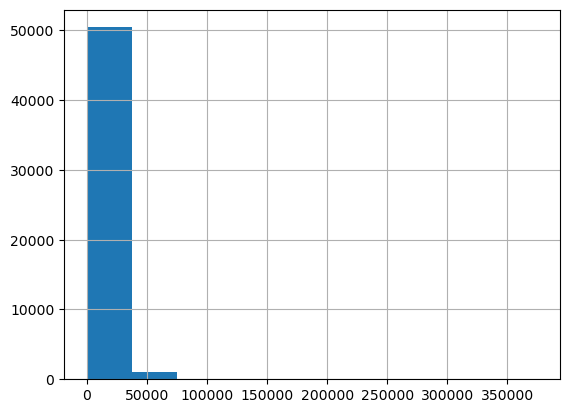

The distribution is skewed to the right
---------------------------------------
Statistics on: price
count     51525.000000
mean      12132.464920
std       10040.803015
min           1.000000
25%        5000.000000
50%        9000.000000
75%       16839.000000
max      375000.000000
Name: price, dtype: float64
---------------------------------------
min border: 371.48
max border: 37995.0
---------------------------------------
The outliers are considered to be values below 371.48 and above 37995.0
We have 2059 values that we can consider outliers
This is 4.0 % of data


In [50]:
#price
distribution_percentile('price')

The price histogram looks a bit weird - it has a dominant peak (where the majority of data is located) and a long tail - the difference between 75th percentile and maximum is quite significant. And this high peek cannot tell us anything about disrtibution - it is all consolidated in one big bin. Beacause of the big difference between 75th percentile and maximum we know that there are a lot of outliers and I decide to use 2nd and 98th percetliles as limits to address them.


The histogram of: age


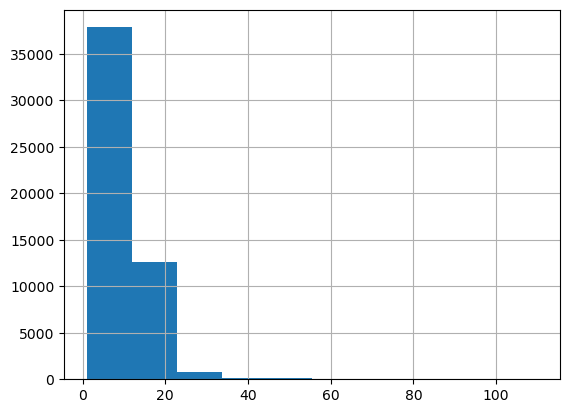

The distribution is skewed to the right
---------------------------------------
Statistics on: age
count    51525.000000
mean         8.470412
std          6.103346
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max        110.000000
Name: age, dtype: float64
---------------------------------------
min border: 1.0
max border: 23.0
---------------------------------------
The outliers are considered to be values below 1.0 and above 23.0
We have 887 values that we can consider outliers
This is 1.72 % of data


In [51]:
#age
distribution_percentile('age')

Same picture in the age histogram - there is a indistinguishable peak, a long tail, big difference between 75th percentile and maximum. I'll set the same limits for outliers.

Next I will use a column `avg_mileage` which represents a vehicle's average yearly mileage. By filtering outliers in this column, I can eliminate vehicles that have not been driven frequently over the years. If I were to filter based on the `odometer` column, it would result in the exclusion of low or high odometer readings (for example, new or old cars), which would not provide meaningful insight into the relationship between mileage and vehicle price.

The histogram of: avg_mileage


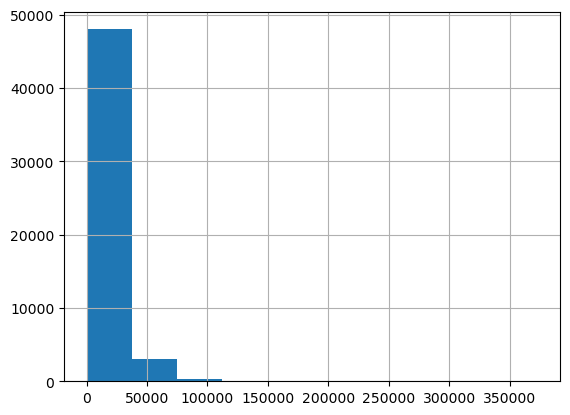

The distribution is skewed to the right
---------------------------------------
Statistics on: avg_mileage
count     51525.000000
mean      18325.692440
std       13647.024051
min           0.000000
25%       10833.330000
50%       15272.730000
75%       21917.000000
max      373200.000000
Name: avg_mileage, dtype: float64
---------------------------------------
min border: 1003.0
max border: 56749.438399999555
---------------------------------------
The outliers are considered to be values below 1003.0 and above 56749.438399999555
We have 2058 values that we can consider outliers
This is 3.99 % of data


In [52]:
#average mileage
distribution_percentile('avg_mileage')




Same picture in as in the price and in the age histogram - there is a indistinguishable peak, a long tail, big difference between 75th percentile and maximum. I'll set the same limits (2nd and 98th percentile) for outliers.

The histogram of: cylinders


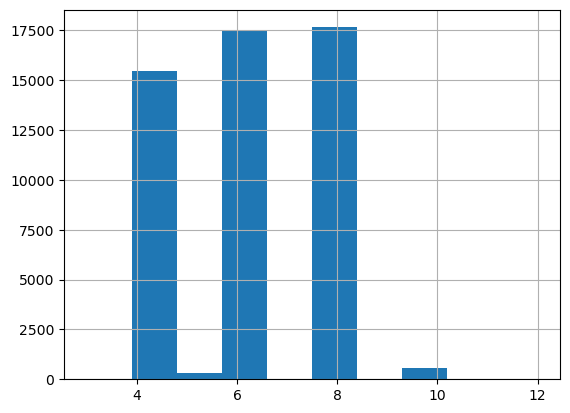

The distribution is skewed to the right
---------------------------------------
Statistics on: cylinders
count    51525.000000
mean         6.122193
std          1.658006
min          3.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         12.000000
Name: cylinders, dtype: float64
---------------------------------------
min border: 4.0
max border: 8.0
---------------------------------------
The outliers are considered to be values below 4.0 and above 8.0
We have 614 values that we can consider outliers
This is 1.19 % of data


In [53]:
#cylinders
distribution_percentile('cylinders')


The distribution of cylinders in the data is evident from the histogram - the most frequent ones are 4, 6, and 8 cylinders. Although 3, 5, 10, and 12 cylinders are less common, they are still a valid representation of the data and do not skew the graphs and I'm not sure I need to filter them out.

The histogram of: condition


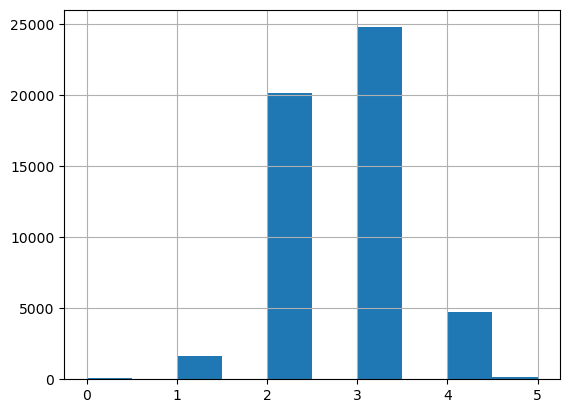

The distribution is skewed to the left
---------------------------------------
Statistics on: condition
count    51525.000000
mean         2.637535
std          0.712447
min          0.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: condition, dtype: float64
---------------------------------------
min border: 1.0
max border: 4.0
---------------------------------------
The outliers are considered to be values below 1.0 and above 4.0
We have 258 values that we can consider outliers
This is 0.5 % of data


In [54]:
#condition
distribution_percentile('condition')


The distribution of `condition` in the data is also pretty evident from the histogram - most of the vehicles tend to be not in very good or very bad shape, but somewhere in the middle.  And as I thought with `cylinders` - filtering extreme values will not help me.



The histograms of `price`, `age`, and `avg_mileage` can be challenging to analyze, so I'm going to implement filters using the 2nd and 98th percentiles as boundaries. This approach minimizes the data loss for further analysis. However, for the `cylinders` and `condition`, I have decided to retain all the data, as filtering will not greatly improve the analysis.

## Study and treat outliers


In [55]:
# Determine the lower limits for outliers
def lower_limit(parameter):
    two = np.percentile(ads[parameter], 2)
    print(parameter,'min border:',two)
    
for parameter in ['price','age','avg_mileage']:
    lower_limit(parameter)




price min border: 371.48
age min border: 1.0
avg_mileage min border: 1003.0


In [56]:
# Determine the upper limits for outliers
def upper_limit(parameter):
    ninety_eight = np.percentile(ads[parameter], 98)
    print(parameter,'max border:',ninety_eight)
    
for parameter in ['price','age','avg_mileage']:
    upper_limit(parameter)


price max border: 37995.0
age max border: 23.0
avg_mileage max border: 56749.438399999555


With the borders determined, I can now create separate dataframes for the data without outliers and the outliers.

In [57]:
# outliers
outliers = ads.query('price<371 or price>37995 or age<1 or age>23 or avg_mileage<1003 or avg_mileage>56749').reset_index(drop=True)
outliers.info()
round(len(outliers)/len(ads)*100, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         4687 non-null   int64         
 1   model_year    4687 non-null   int64         
 2   model         4687 non-null   object        
 3   condition     4687 non-null   int64         
 4   cylinders     4687 non-null   int64         
 5   fuel          4687 non-null   object        
 6   odometer      4687 non-null   float64       
 7   transmission  4687 non-null   object        
 8   type          4687 non-null   object        
 9   paint_color   4687 non-null   object        
 10  is_4wd        4687 non-null   int64         
 11  date_posted   4687 non-null   datetime64[ns]
 12  days_listed   4687 non-null   int64         
 13  year_posted   4687 non-null   int64         
 14  month_posted  4687 non-null   int64         
 15  day_posted    4687 non-null   int64   

9.1

In [58]:
# Store data without outliers in a separate DataFrame
ads_without_outliers = ads.query(
    '(371<= price <=37995) and (1<= age <=23) and (1003<= avg_mileage <=56749)').reset_index(drop=True)
ads_without_outliers.info()
ads_without_outliers.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46838 entries, 0 to 46837
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         46838 non-null  int64         
 1   model_year    46838 non-null  int64         
 2   model         46838 non-null  object        
 3   condition     46838 non-null  int64         
 4   cylinders     46838 non-null  int64         
 5   fuel          46838 non-null  object        
 6   odometer      46838 non-null  float64       
 7   transmission  46838 non-null  object        
 8   type          46838 non-null  object        
 9   paint_color   46838 non-null  object        
 10  is_4wd        46838 non-null  int64         
 11  date_posted   46838 non-null  datetime64[ns]
 12  days_listed   46838 non-null  int64         
 13  year_posted   46838 non-null  int64         
 14  month_posted  46838 non-null  int64         
 15  day_posted    46838 non-null  int64 

,price,model_year,condition,cylinders,odometer,is_4wd,days_listed,year_posted,month_posted,day_posted,age,avg_mileage
count,46838.000000,46838.000000,46838.000000,46838.000000,46838.000000,46838.000000,46838.000000,46838.000000,46838.000000,46838.000000,46838.000000,46838.000000
mean,11661.509095,2009.969960,2.620885,6.062492,119853.308019,0.488343,39.564776,2018.310837,6.608523,15.446176,8.369380,17499.674791
std,8112.908612,5.021101,0.702875,1.627567,58968.958481,0.499869,28.218916,0.462841,3.478518,8.731399,4.983412,9325.404677
min,372.000000,1995.000000,0.000000,3.000000,1011.000000,0.000000,0.000000,2018.000000,1.000000,1.000000,1.000000,1011.000000
25%,5300.000000,2007.000000,2.000000,4.000000,79520.750000,0.000000,19.000000,2018.000000,3.000000,8.000000,4.000000,11184.252500
50%,9000.000000,2011.000000,3.000000,6.000000,118000.000000,0.000000,33.000000,2018.000000,7.000000,15.000000,8.000000,15333.330000
75%,16000.000000,2014.000000,3.000000,8.000000,156000.000000,1.000000,53.000000,2019.000000,10.000000,23.000000,12.000000,21488.050000
max,37995.000000,2019.000000,5.000000,12.000000,920000.000000,1.000000,271.000000,2019.000000,12.000000,31.000000,23.000000,56677.330000


Approximately 9% of the data was identified as outliers and removing them is crucial for the analysis. Keeping these outliers would complicate the analysis, as they make the information difficult to interpret.

## Study core parameters without outliers

I'll use the filtered data to make new plots and compare with the earlier ones (that included outliers).

The histogram with outliers of: price


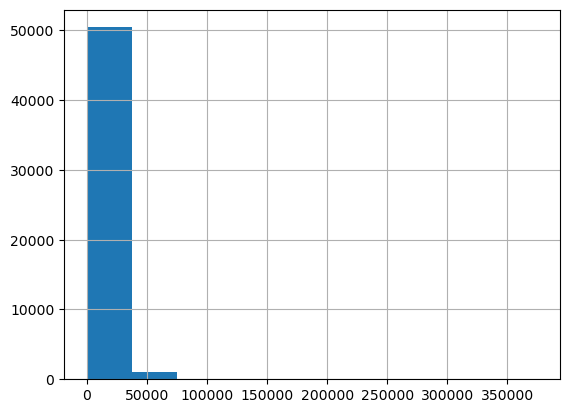

The histogram without outliers of: price


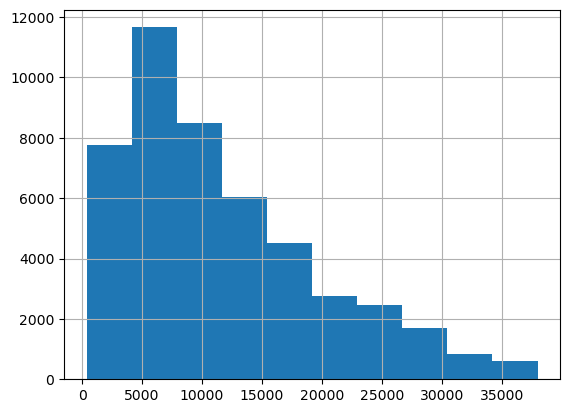

---------------------------------------
The distribution is skewed to the right
---------------------------------------
Statistics on: price
count    46838.000000
mean     11661.509095
std       8112.908612
min        372.000000
25%       5300.000000
50%       9000.000000
75%      16000.000000
max      37995.000000
Name: price, dtype: float64
---------------------------------NEXT-PARAMETER-------------------------------------------
---------------------------------NEXT-PARAMETER-------------------------------------------
The histogram with outliers of: age


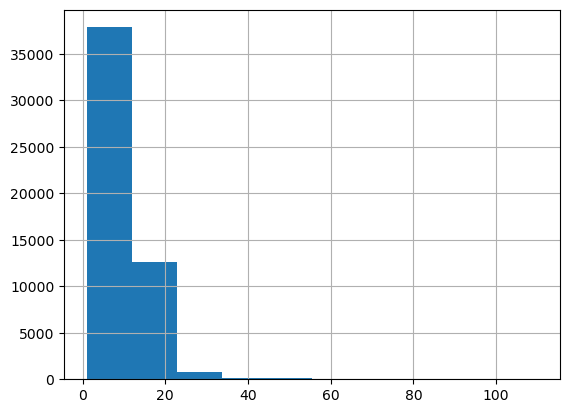

The histogram without outliers of: age


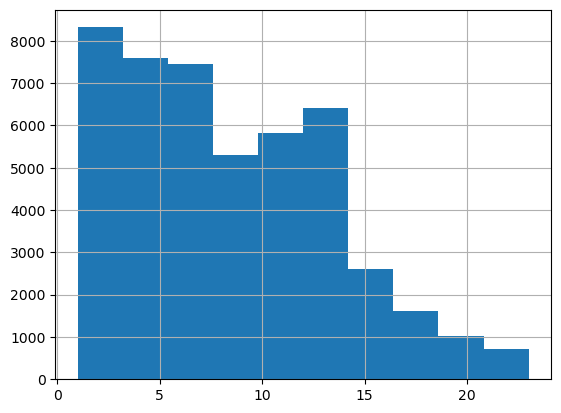

---------------------------------------
The distribution is skewed to the right
---------------------------------------
Statistics on: age
count    46838.000000
mean         8.369380
std          4.983412
min          1.000000
25%          4.000000
50%          8.000000
75%         12.000000
max         23.000000
Name: age, dtype: float64
---------------------------------NEXT-PARAMETER-------------------------------------------
---------------------------------NEXT-PARAMETER-------------------------------------------
The histogram with outliers of: avg_mileage


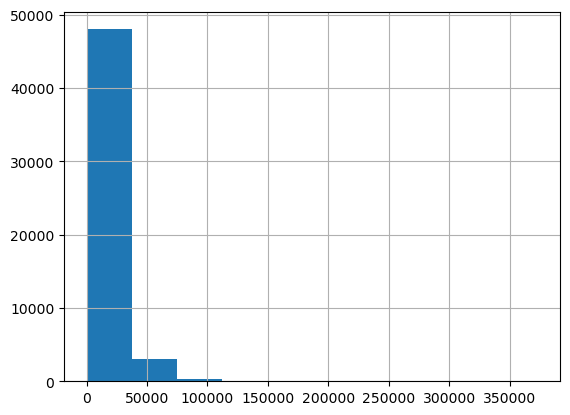

The histogram without outliers of: avg_mileage


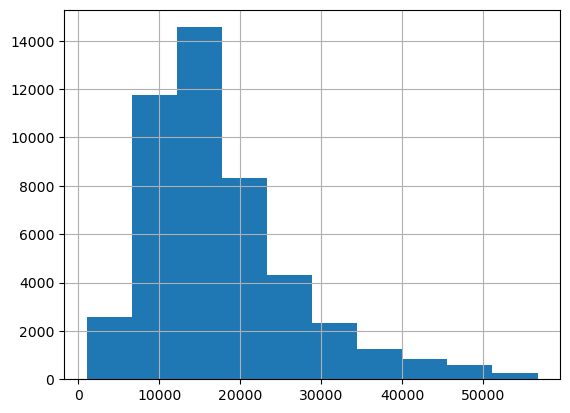

---------------------------------------
The distribution is skewed to the right
---------------------------------------
Statistics on: avg_mileage
count    46838.000000
mean     17499.674791
std       9325.404677
min       1011.000000
25%      11184.252500
50%      15333.330000
75%      21488.050000
max      56677.330000
Name: avg_mileage, dtype: float64
---------------------------------NEXT-PARAMETER-------------------------------------------
---------------------------------NEXT-PARAMETER-------------------------------------------


In [59]:
def distribution_good_data(parameter):
    print('The histogram with outliers of: {}'.format(parameter))
    ads[parameter].hist()
    plt.show()
    print('The histogram without outliers of: {}'.format(parameter))
    ads_without_outliers[parameter].hist()
    plt.show()
    print('---------------------------------------')
    if ads_without_outliers[parameter].mean()>ads_without_outliers[parameter].median():
        print('The distribution is skewed to the right')
    else:
        print('The distribution is skewed to the left')
    print('---------------------------------------')
    print('Statistics on: {}'.format(parameter))
    print(ads_without_outliers[parameter].describe())
    print('---------------------------------NEXT-PARAMETER-------------------------------------------')
    print('---------------------------------NEXT-PARAMETER-------------------------------------------')    

for parameter in ['price','age','avg_mileage']:
    distribution_good_data(parameter)
    

The revised histograms provide a clearer understanding of the data - the distributions are now easily understandable.

* In the `price` histogram, there is a strong demand for budget-friendly cars with the most frequently advertised cars costing around 4-7 thousand.
* The `age` histogram reveals a high concentration of relatively new cars, with the most frequent ages falling between 1-3 years.
* The `avg_mileage` histogram shows that the most frequent average yearly mileage is between 12-17 thousand miles.

## Ads lifetime

Let's also study how many days advertisements were displayed. 
I'll calculate the mean and median in order to describe the typical lifetime of an ad. 
I'll determine when ads were removed quickly, and when they were listed for an abnormally long time.

In [60]:
ads.days_listed.describe()
np.percentile(ads.days_listed, 2)
np.percentile(ads.days_listed, 98)

count    51525.00000
mean        39.55476
std         28.20427
min          0.00000
25%         19.00000
50%         33.00000
75%         53.00000
max        271.00000
Name: days_listed, dtype: float64

4.0

115.0

In [61]:
ads.query('days_listed <= 4 or days_listed >= 115')['days_listed'].count()
len(ads.query('days_listed <= 4 or days_listed >= 115'))/len(ads)*100

2361

4.582241630276565

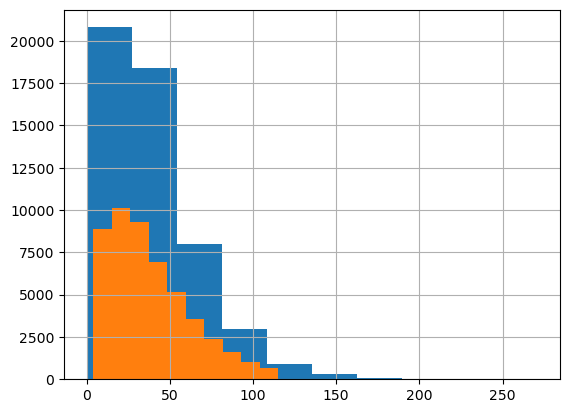

In [62]:
good_days_listed = ads.query('4 <= days_listed <= 115')

ads.days_listed.hist()
good_days_listed.days_listed.hist();


From the general information, I notice that the minimum value in `days_listed` is zero, indicating that some cars were sold within a day.
The median value is 33, meaning that half of the cars were sold within a month. Majority of cars (75% of the data) shows that the ads were listed for less than 53 days.
The mean value is 39, which is higher than the median due to the presence of outliers. The outliers are identified as ads listed for less than 4 days and more than 115 days (based on the 2nd and 98th percentiles).

## Average price per each type of vehicle

I plan to examine the number of ads and the average price for each type of vehicle. Afterwards, I will plot a graph to display the relationship between the number of ads and the type of vehicle.

In [63]:
vehicle_types = ads_without_outliers.groupby(
    ['type'])['price'].agg(
    ['count','mean']).sort_values(by='count', ascending=False)
vehicle_types

,count,mean
type,,
SUV,11428,10872.710361
sedan,11329,7035.308412
truck,10918,15821.988093
pickup,6385,15336.144088
coupe,1908,14102.208595
wagon,1464,9000.439891
mini-van,1109,7958.153291
hatchback,958,6885.161795
van,592,10880.880068


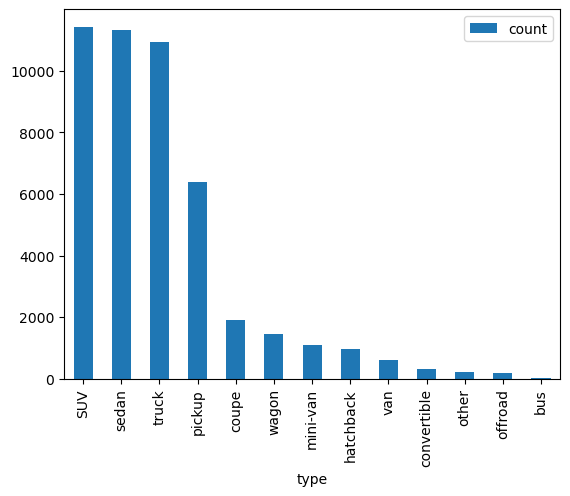

In [64]:
vehicle_types.plot(y='count', kind='bar');


As I see there are three obvious leaders in our dataset - SUVs, sedans and trucks are the most avertised cars. I'll select two of them - SUVs and sedans - for the further analysis. 

## Price factors

The next step is to identify the factors that have the greatest impact on the price. I will focus on two popular vehicle types identified in the previous stage and investigate the influence of age, mileage, condition, transmission type, and color on the price.

For categorical variables (transmission type and color), I will use box-and-whisker plots, and for the remaining variables, I will create scatterplots to visualize the relationships.


In [65]:
suv = ads_without_outliers.query('type == "SUV"')
suv_scatter=suv[['price', 'age', 'odometer','condition']]

suv_scatter.corr()


,price,age,odometer,condition
price,1.000000,-0.644356,-0.649243,0.299300
age,-0.644356,1.000000,0.659552,-0.310628
odometer,-0.649243,0.659552,1.000000,-0.354587
condition,0.299300,-0.310628,-0.354587,1.000000


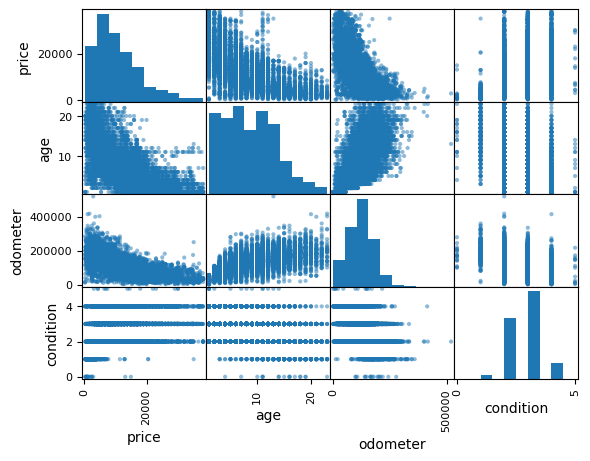

In [66]:
pd.plotting.scatter_matrix(suv_scatter);

The correlation table and scatter matrix reveal a strong negative relationship between price and both age and mileage. As the age or mileage of a vehicle increases, the price decreases. There is also a present correlation between price and condition, with better condition potentially leading to a higher price.

In [67]:
suv.groupby(['paint_color'])['price'].describe().sort_values(by='mean', ascending=False)
suv.groupby(['transmission'])['price'].describe().sort_values(by='count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
paint_color,,,,,,,,
orange,76.0,15592.315789,6919.291546,900.0,10743.25,16900.0,18101.25,36000.0
yellow,43.0,15239.348837,9513.000553,500.0,7900.00,13900.0,21797.00,37995.0
black,1992.0,12672.923695,7895.472569,399.0,6287.50,11500.0,16900.00,37995.0
white,1808.0,11953.557522,7997.052689,500.0,5990.00,9950.0,15995.00,37995.0
unknown,2047.0,11034.449927,7495.876526,400.0,5500.00,8977.0,14995.00,37995.0
grey,1104.0,10716.048913,7354.658431,500.0,5000.00,8736.0,14499.25,36700.0
silver,1468.0,10146.899183,6467.356821,483.0,5200.00,8495.0,13950.00,36988.0
custom,275.0,10088.109091,6377.377381,800.0,5747.50,8700.0,12990.00,35000.0
red,856.0,9996.703271,7007.060495,450.0,4650.00,7989.0,13991.25,37499.0


,count,mean,std,min,25%,50%,75%,max
transmission,,,,,,,,
automatic,10881.0,10818.395276,7389.250308,372.0,5250.0,8900.0,14900.0,37995.0
manual,457.0,11806.571116,6744.029878,500.0,6500.0,11000.0,16500.0,36000.0
other,90.0,12697.466667,5874.972226,2000.0,7995.0,12900.0,17212.5,28999.0


In [68]:
suv = suv.query('paint_color != "purple" and paint_color != "yellow" and paint_color != "orange" and transmission != "other"')

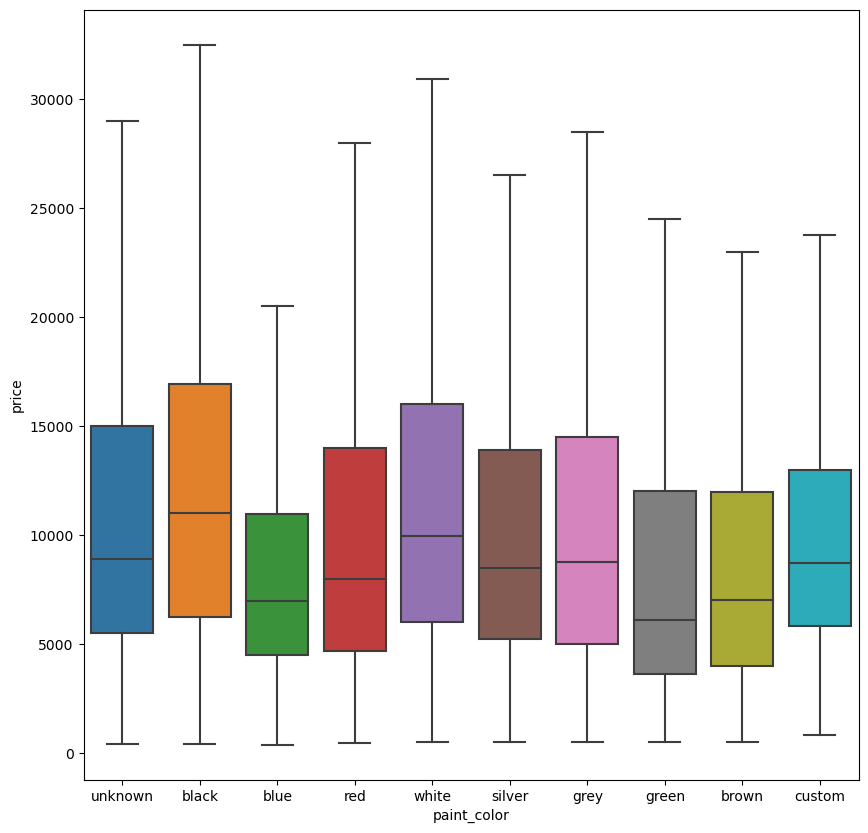

In [69]:
plt.figure(figsize=(10,10))
ax=sns.boxplot(x="paint_color", y="price", data=suv,showfliers = False);

The `paint_color` boxplot shows that black and white SUVs tend to have higher prices. And the cheapest ones are green.

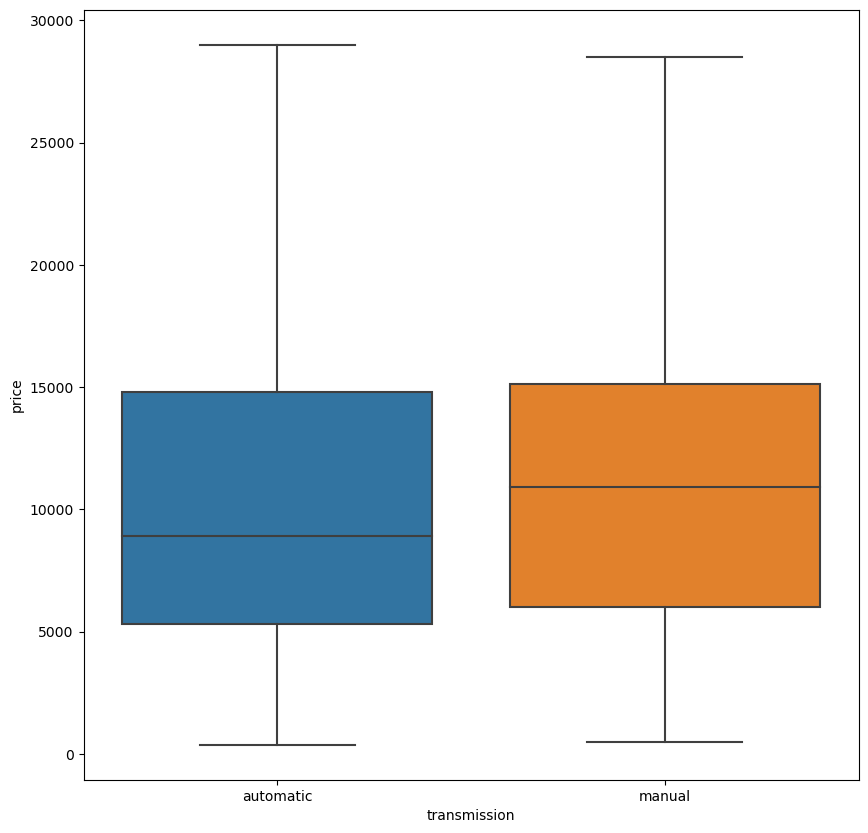

In [70]:
plt.figure(figsize=(10,10))
ax=sns.boxplot(x='transmission', y='price', data=suv,showfliers = False);

The prices of manual and automatic transmissions are quite similar, with slight variations. The majority of automatic SUVs tend to be slightly cheaper, but with a higher maximum price. Meanwhile, the majority of manual vehicles are slightly more expensive, but with a lower maximum price.

Now let's look at the sedans!

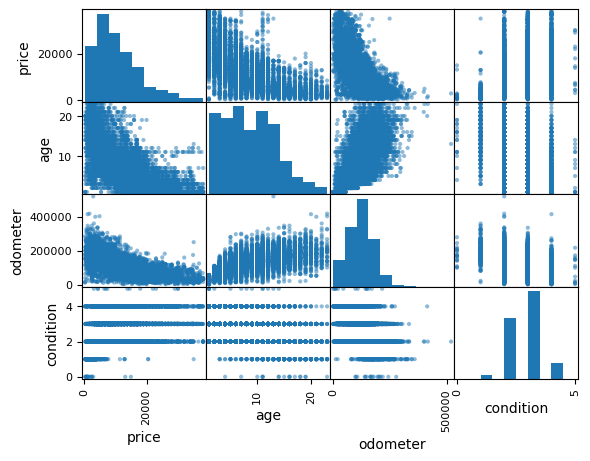

In [71]:
sedan = ads_without_outliers.query('type == "sedan"')
sedan_scatter=suv[['price', 'age', 'odometer','condition']]

sedan_scatter.corr()
pd.plotting.scatter_matrix(suv_scatter);

The results for this dataset are similar to those for SUVs - the correlation table and scatter matrix show a strong negative relationship between price and both age and mileage. As the age or mileage of a vehicle increases, the price decreases. Additionally, there is a present correlation between price and condition, with better condition potentially leading to a higher price.

In [72]:
sedan.groupby(['paint_color'])['price'].describe().sort_values(by='mean', ascending=False)
sedan.groupby(['transmission'])['price'].describe().sort_values(by='count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
paint_color,,,,,,,,
orange,9.0,10593.888889,7592.428769,1950.0,5300.00,8902.0,15998.00,21900.0
white,1388.0,7588.890490,4286.116639,399.0,4500.00,6769.5,9995.00,31000.0
black,1640.0,7569.701220,4221.999275,399.0,4399.75,6900.0,9995.00,32999.0
red,872.0,7154.918578,4165.335872,500.0,4000.00,5995.0,9399.00,25390.0
unknown,2037.0,7034.515464,4177.118276,399.0,3995.00,5999.0,9250.00,32999.0
grey,1532.0,7023.404047,3818.510981,399.0,4386.75,6200.0,8995.00,29777.0
custom,257.0,6965.474708,4230.331936,500.0,3800.00,5995.0,8995.00,23995.0
silver,1940.0,6908.181959,4078.773301,400.0,3987.50,5995.0,8995.00,28000.0
blue,1163.0,6576.005159,4088.360598,500.0,3900.00,5699.0,8288.00,25947.0


,count,mean,std,min,25%,50%,75%,max
transmission,,,,,,,,
automatic,10708.0,7110.102260,4133.900979,399.0,3999.0,6000.0,9200.0,32999.0
manual,555.0,5528.333333,3786.156492,400.0,2995.0,4500.0,6990.0,25000.0
other,66.0,7572.863636,3875.933237,1800.0,5062.5,5995.0,9998.0,20700.0


In [73]:
sedan = sedan.query('paint_color != "purple" and paint_color != "yellow" and paint_color != "orange" and transmission != "other"')

<Figure size 1000x1000 with 0 Axes>

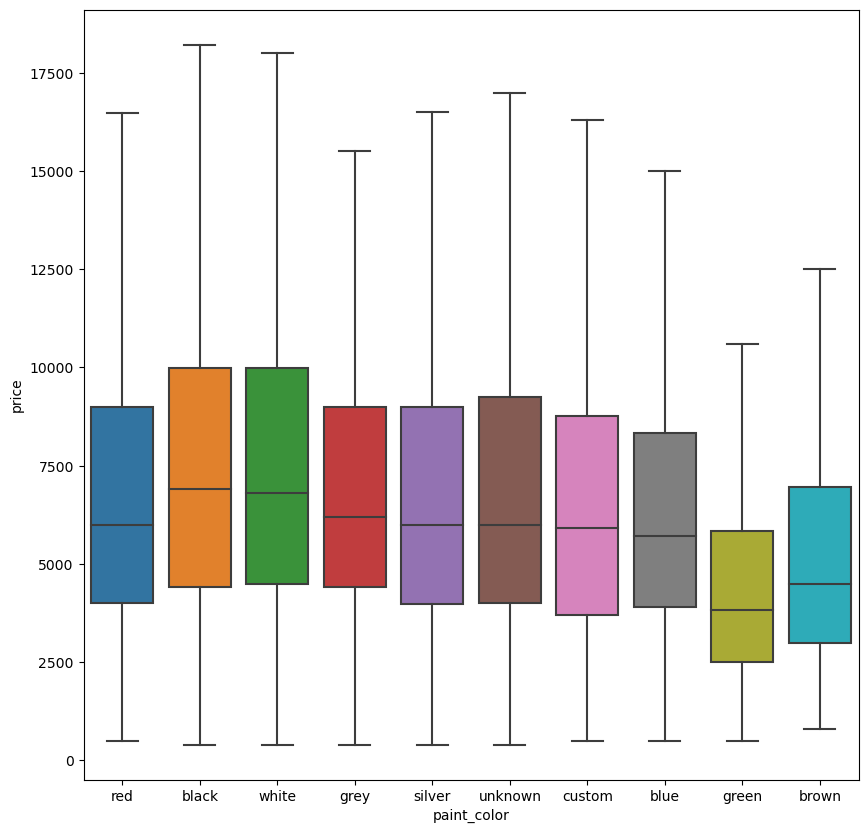

In [74]:
plt.figure(figsize=(10,10))
ax=sns.boxplot(x='paint_color', y='price', data=sedan,showfliers = False)

For sedans, the same trend is seen as with SUVs - black and white colors are the most expensive, while green is the least expensive.

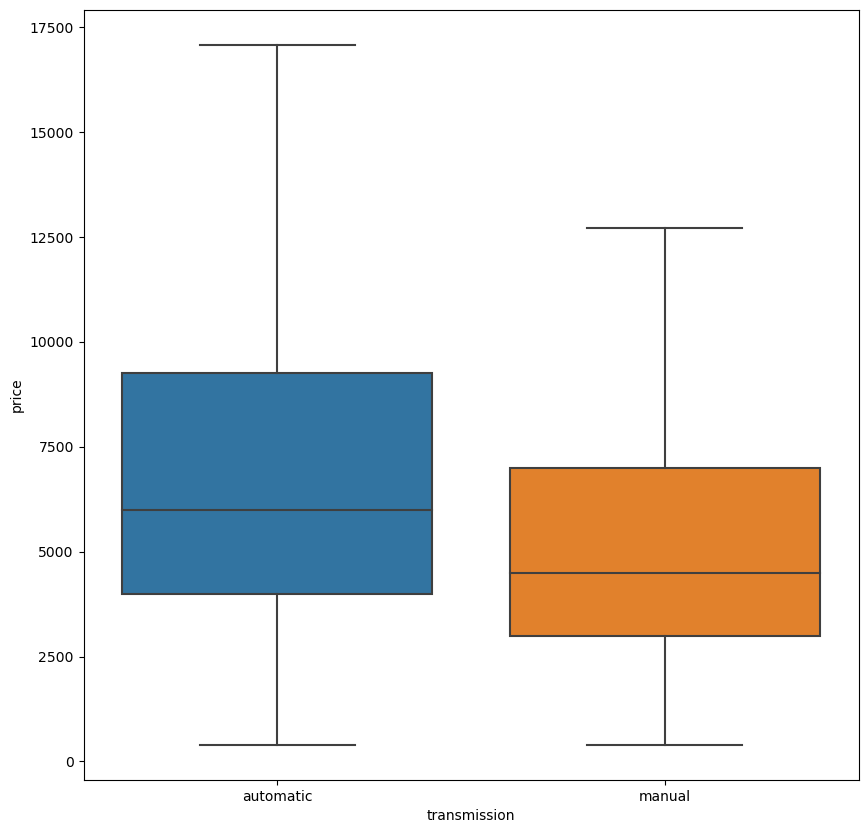

In [75]:
plt.figure(figsize=(10,10))
ax=sns.boxplot(x='transmission', y='price', data=sedan,showfliers = False);

For sedan transmissions, automatic vehicles are more expensive than their manual counterparts.

## General conclusion

During my data analysis process, I encountered several challenges that had to be addressed to ensure the analysis could be carried out effectively. These challenges included:

* Missing values across the entire dataset;
* Incorrect datatypes in some columns;
* The presence of outliers in most of the crucial columns, which distorted the overall picture of the data.

To overcome these challenges, I filtered the original dataset by removing the outliers that were affecting the data. This process resulted in the elimination of approximately 9% of the data.

Next, I aimed to identify the factors that could influence the price of a vehicle. Here are my findings:

1. The age and mileage of a vehicle have the most significant impact on its price - as a vehicle gets older, its price decreases, and the higher the mileage, the lower the price.
2. The condition of a car also affects its price - a car in better condition will command a higher price.
3. Color is another factor that needs to be taken into account - in our dataset, black or white cars were the most expensive, while green cars were the least expensive.
4. The impact of a car's transmission type was not as clear. In the case of one of the most popular types of cars (SUVs), prices for automatic and manual transmission were similar. For another type (sedans), cars with automatic transmission were slightly more expensive than those with manual transmission.
